In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
# Идея - вероятность покупки следующих N товаров, при том, что у покупателя уже есть N тоааров
# Multi-model ranking
# По товарам в наличии?? (Вероятность товара в наличии?)

In [3]:
data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

In [4]:
print(data.shape)

data.memory_usage(deep=True).divide(1024 ** 3).round(3)

(31788324, 5)


Index               0.000
t_dat               1.984
customer_id         3.582
article_id          0.237
price               0.237
sales_channel_id    0.237
dtype: float64

In [5]:
data.info(null_counts=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Non-Null Count     Dtype  
---  ------            --------------     -----  
 0   t_dat             31788324 non-null  object 
 1   customer_id       31788324 non-null  object 
 2   article_id        31788324 non-null  int64  
 3   price             31788324 non-null  float64
 4   sales_channel_id  31788324 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [6]:
data.customer_id.nunique(), data.article_id.nunique(), data.sales_channel_id.nunique()

(1362281, 104547, 2)

count    1362281.000
mean          23.335
std           39.242
min            1.000
10%            2.000
20%            3.000
30%            4.000
40%            6.000
50%            9.000
60%           14.000
70%           21.000
80%           34.000
90%           60.000
max         1895.000
Name: t_dat, dtype: float64


<AxesSubplot:>

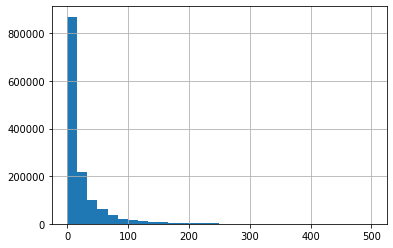

In [7]:
cnt = data.groupby('customer_id').t_dat.count()

print(cnt.describe(percentiles=np.arange(.1, 1, .1)).round(3))

cnt.hist(bins=30, range=(0, 500))

<AxesSubplot:>

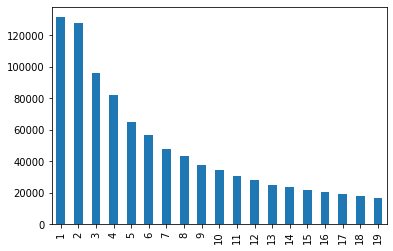

In [8]:
cnt.loc[lambda x: x < 20].value_counts().plot.bar()

count    104547.000
mean        304.058
std         791.266
min           1.000
10%           4.000
20%           9.000
30%          19.000
40%          36.000
50%          65.000
60%         117.000
70%         211.000
80%         388.000
90%         793.000
max       50287.000
Name: t_dat, dtype: float64


<AxesSubplot:>

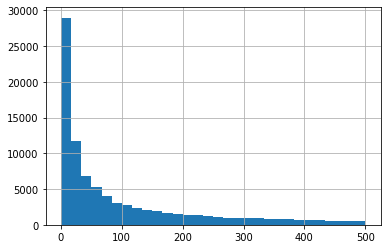

In [9]:
cnt = data.groupby('article_id').t_dat.count()

print(cnt.describe(percentiles=np.arange(.1, 1, .1)).round(3))

cnt.hist(bins=30, range=(0, 500))

<AxesSubplot:>

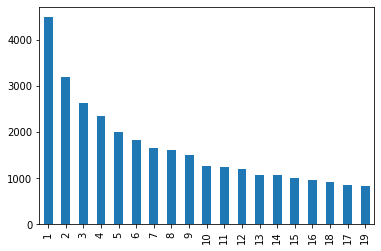

In [10]:
cnt.loc[lambda x: x < 20].value_counts().plot.bar()

count    3.178832e+07
mean     2.800000e-02
std      1.900000e-02
min      0.000000e+00
10%      1.000000e-02
20%      1.400000e-02
30%      1.700000e-02
40%      2.000000e-02
50%      2.500000e-02
60%      2.700000e-02
70%      3.400000e-02
80%      3.800000e-02
90%      5.100000e-02
max      5.920000e-01
Name: price, dtype: float64


<AxesSubplot:>

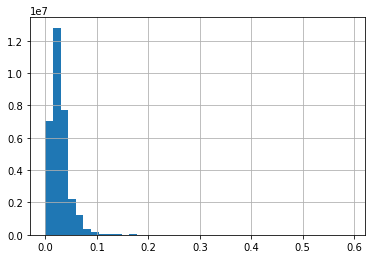

In [11]:
print(data.price.describe(percentiles=np.arange(.1, 1, .1)).round(3))

data.price.hist(bins=40)

In [12]:
data.sales_channel_id.value_counts()

2    22379862
1     9408462
Name: sales_channel_id, dtype: int64

In [13]:
data.t_dat = data.t_dat.astype('datetime64')

<AxesSubplot:xlabel='t_dat'>

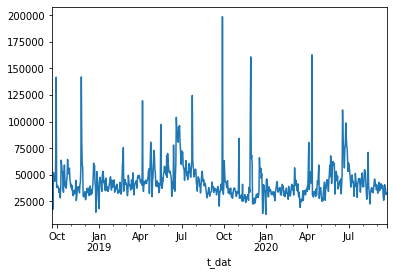

In [14]:
data.groupby('t_dat').size().sort_index().asfreq('d').plot()

# У нас есть только два года наблюдений
# Сезонность явно годовая, летом продажи больше, зимой меньше

In [15]:
data.t_dat.agg(['min', 'max'])

min   2018-09-20
max   2020-09-22
Name: t_dat, dtype: datetime64[ns]

<AxesSubplot:xlabel='t_dat'>

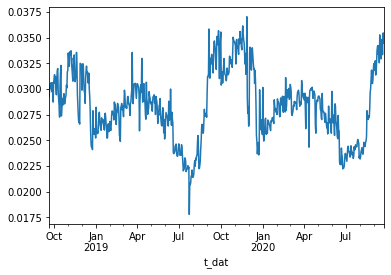

In [16]:
# Зимой средний чек меньше, летом больше

data.groupby('t_dat').price.mean().sort_index().asfreq('d').plot()

<AxesSubplot:>

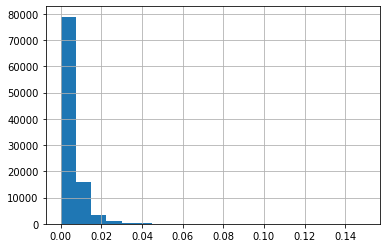

In [17]:
data.groupby('article_id').price.std().hist(bins=20)

<AxesSubplot:xlabel='t_dat'>

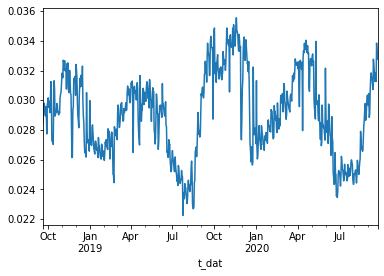

In [18]:
data.groupby(['t_dat', 'article_id']).price.mean().groupby(level=0).mean().plot()

In [19]:
customers = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/customers.csv')

In [20]:
print(customers.shape)

customers.info(null_counts=True)

(1371980, 7)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: null_counts is deprecated. Use show_counts instead
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [21]:
#

cnt = customers.postal_code.value_counts()

cnt.head()

2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    120303
cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8       261
714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1       159
7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7       157
5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145       156
Name: postal_code, dtype: int64

In [22]:
# Почему у большинства покупателей один и тот же индекс??

cnt.divide(cnt.sum()).multiply(100).round(3).apply('{}%'.format).head()

2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    8.769%
cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8    0.019%
714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1    0.012%
7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7    0.011%
5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145    0.011%
Name: postal_code, dtype: object

In [23]:
customers.club_member_status.value_counts(dropna=False)

ACTIVE        1272491
PRE-CREATE      92960
NaN              6062
LEFT CLUB         467
Name: club_member_status, dtype: int64

In [24]:
customers.FN.value_counts(dropna=False)

NaN    895050
1.0    476930
Name: FN, dtype: int64

In [25]:
customers.fashion_news_frequency.value_counts(dropna=False)

NONE         877711
Regularly    477416
NaN           16009
Monthly         842
None              2
Name: fashion_news_frequency, dtype: int64

<AxesSubplot:>

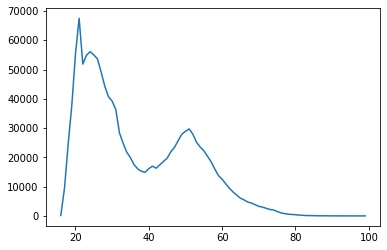

In [26]:
customers.age.value_counts().sort_index().plot()

<AxesSubplot:xlabel='age'>

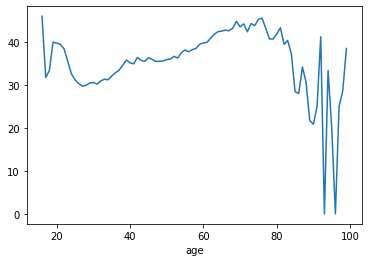

In [27]:
customers.fillna({'FN': 0}).groupby('age').FN.mean().multiply(100).plot()

In [28]:
articles = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv')

In [29]:
print(articles.shape)

articles.isna().sum()

(105542, 25)


article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

In [30]:
articles.product_code

0         108775
1         108775
2         108775
3         110065
4         110065
           ...  
105537    953450
105538    953763
105539    956217
105540    957375
105541    959461
Name: product_code, Length: 105542, dtype: int64

In [31]:
code_name = articles.groupby(['product_code']).prod_name.nunique()

In [32]:
code_name.loc[(code_name > 2)]

product_code
188183    3
288825    3
291333    4
291338    4
293244    3
         ..
864040    3
865261    3
865490    3
898918    3
904545    3
Name: prod_name, Length: 334, dtype: int64

In [33]:
# prod_name useless

articles[articles.product_code == 291333]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
732,291333007,291333,2-p Keri,304,Underwear Tights,Socks & Tights,1010016,Solid,10,White,...,Kids Girl S&T,H,Children Sizes 92-140,4,Baby/Children,79,Girls Underwear & Basics,1021,Socks and Tights,"Tights in a soft, fine-knit cotton blend with ..."
733,291333012,291333,2-p Keri tights SG,304,Underwear Tights,Socks & Tights,1010013,Other pattern,9,Black,...,Kids Girl S&T,H,Children Sizes 92-140,4,Baby/Children,79,Girls Underwear & Basics,1021,Socks and Tights,"Tights in a soft, fine-knit cotton blend with ..."
734,291333013,291333,2-p Keri tights SG,304,Underwear Tights,Socks & Tights,1010013,Other pattern,51,Light Pink,...,Kids Girl S&T,H,Children Sizes 92-140,4,Baby/Children,79,Girls Underwear & Basics,1021,Socks and Tights,"Tights in a soft, fine-knit cotton blend with ..."
735,291333014,291333,2-p Keri tights SG,304,Underwear Tights,Socks & Tights,1010013,Other pattern,73,Dark Blue,...,Kids Girl S&T,H,Children Sizes 92-140,4,Baby/Children,79,Girls Underwear & Basics,1021,Socks and Tights,"Tights in a soft, fine-knit cotton blend with ..."
736,291333015,291333,Keri 2PACK tights SG,304,Underwear Tights,Socks & Tights,1010016,Solid,51,Light Pink,...,Kids Girl S&T,H,Children Sizes 92-140,4,Baby/Children,79,Girls Underwear & Basics,1021,Socks and Tights,"Tights in a soft, fine-knit cotton blend with ..."
737,291333016,291333,2-p Keri tights SG,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,Kids Girl S&T,H,Children Sizes 92-140,4,Baby/Children,79,Girls Underwear & Basics,1021,Socks and Tights,"Tights in a soft, fine-knit cotton blend with ..."
738,291333018,291333,2-p Keri tights SG,304,Underwear Tights,Socks & Tights,1010016,Solid,6,Light Grey,...,Kids Girl S&T,H,Children Sizes 92-140,4,Baby/Children,79,Girls Underwear & Basics,1021,Socks and Tights,"Tights in a soft, fine-knit cotton blend with ..."
739,291333019,291333,2-p Keri tights SG,304,Underwear Tights,Socks & Tights,1010016,Solid,11,Off White,...,Kids Girl S&T,H,Children Sizes 92-140,4,Baby/Children,79,Girls Underwear & Basics,1021,Socks and Tights,"Tights in a soft, fine-knit cotton blend with ..."
740,291333021,291333,2-p Keri tights SG,304,Underwear Tights,Socks & Tights,1010016,Solid,11,Off White,...,Kids Girl S&T,H,Children Sizes 92-140,4,Baby/Children,79,Girls Underwear & Basics,1021,Socks and Tights,"Tights in a soft, fine-knit cotton blend with ..."
741,291333023,291333,Keri 2pk tights SG,304,Underwear Tights,Socks & Tights,1010016,Solid,6,Light Grey,...,Kids Girl S&T,H,Children Sizes 92-140,4,Baby/Children,79,Girls Underwear & Basics,1021,Socks and Tights,"Tights in a soft, fine-knit cotton blend with ..."


In [34]:
articles.nunique()

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

In [35]:
articles.groupby('product_type_name').product_type_no.nunique().loc[lambda x: x > 1]

product_type_name
Umbrella    2
Name: product_type_no, dtype: int64

In [36]:
# product_type_no useless

articles.loc[articles.product_type_name == 'Umbrella'].product_type_no.value_counts()

83     26
532     3
Name: product_type_no, dtype: int64

In [37]:
articles.product_type_name.value_counts().head()

Trousers    11169
Dress       10362
Sweater      9302
T-shirt      7904
Top          4155
Name: product_type_name, dtype: int64

In [38]:
article_stat = data.groupby('article_id').price.agg(['count', 'mean', 'sum']).reset_index()

In [39]:
articles = articles.merge(article_stat, how='left', on='article_id')

In [40]:
articles.groupby('product_type_name')['sum'].sum().sort_values(ascending=False)

product_type_name
Trousers         150908.046237
Dress            118185.796576
Sweater           80732.982881
Blouse            42424.630475
Jacket            40422.762017
                     ...      
Bumbag                0.243797
Wood balls            0.165068
Clothing mist         0.092271
Toy                   0.044424
Pre-walkers           0.000000
Name: sum, Length: 131, dtype: float64

In [41]:
articles.groupby('product_type_name')['mean'].mean().sort_values(ascending=False)

product_type_name
Coat           0.115053
Blazer         0.068483
Jacket         0.060538
Boots          0.057244
Flat shoes     0.051650
                 ...   
Hair string    0.005574
Hair ties      0.005297
Wood balls     0.004716
Marker pen     0.003210
Pre-walkers         NaN
Name: mean, Length: 131, dtype: float64

In [42]:
# Ориентируемся именно на то, что чаще покупают

articles.groupby('product_type_name')['count'].sum().sort_values(ascending=False)

product_type_name
Trousers         4217017.0
Dress            3238428.0
Sweater          2783274.0
T-shirt          2203750.0
Top              1583408.0
                   ...    
Towel                 20.0
Bumbag                16.0
Toy                    5.0
Clothing mist          4.0
Pre-walkers            0.0
Name: count, Length: 131, dtype: float64

In [43]:
articles.graphical_appearance_name.value_counts()

Solid                  49747
All over pattern       17165
Melange                 5938
Stripe                  4990
Denim                   4842
Front print             3215
Placement print         3098
Check                   2178
Colour blocking         1830
Lace                    1513
Other structure         1502
Application/3D          1341
Embroidery              1165
Mixed solid/pattern     1132
Glittering/Metallic      958
Jacquard                 830
Sequin                   806
Dot                      681
Treatment                586
Other pattern            515
Contrast                 376
Metallic                 346
Chambray                 322
Slub                     153
Transparent               86
Mesh                      86
Neps                      66
Unknown                   52
Argyle                    15
Hologram                   8
Name: graphical_appearance_name, dtype: int64

In [44]:
# Возможно следует учесть такую штуку, как тренд
# Стоит разделить признаки - часть из них учесть по последним данным, часть циклично (проверить гипотезу)
# Частота продаж по категории коррелирует с количеством проданных единици товара?

articles.groupby('graphical_appearance_name')['count'].sum().sort_values(ascending=False)

graphical_appearance_name
Solid                  17849931.0
All over pattern        3972970.0
Denim                   1970734.0
Melange                 1900654.0
Stripe                  1450762.0
Other structure          726854.0
Check                    591383.0
Lace                     589724.0
Placement print          431713.0
Front print              321195.0
Embroidery               311322.0
Dot                      243926.0
Colour blocking          240190.0
Glittering/Metallic      187392.0
Jacquard                 174815.0
Contrast                 174796.0
Application/3D           137650.0
Treatment                113115.0
Mixed solid/pattern       71959.0
Sequin                    69282.0
Metallic                  61458.0
Mesh                      40720.0
Other pattern             40272.0
Chambray                  35701.0
Neps                      30304.0
Slub                      21141.0
Transparent               18072.0
Unknown                    9022.0
Argyle                

In [45]:
articles.groupby('perceived_colour_value_name')['count'].sum().sort_values(ascending=False)

perceived_colour_value_name
Dark            15589563.0
Dusty Light      5405347.0
Light            4573873.0
Medium Dusty     3755532.0
Medium           1231992.0
Bright           1205395.0
Undefined          21027.0
Unknown             5595.0
Name: count, dtype: float64

In [46]:


articles.groupby('perceived_colour_master_name')['count'].sum().sort_values(ascending=False)

perceived_colour_master_name
Black              10962095.0
White               4220669.0
Blue                4194445.0
Beige               2061606.0
Grey                1902708.0
Pink                1594447.0
Red                 1545034.0
Green                937512.0
Khaki green          895492.0
Yellow               740676.0
Orange               690613.0
Brown                623637.0
Metal                371250.0
Mole                 333155.0
Unknown              270990.0
Turquoise            226801.0
Lilac Purple         195072.0
undefined             21027.0
Yellowish Green         930.0
Bluish Green            165.0
Name: count, dtype: float64

In [47]:
# useless?? Товары которые п

articles.department_name.value_counts()

Jersey                             4604
Knitwear                           3503
Trouser                            2655
Blouse                             2362
Dress                              2087
                                   ... 
Woven bottoms inactive from S.7       1
Jersey inactive from S.6              1
EQ Divided Blue                       1
Accessories Other                     1
Kids Boy License                      1
Name: department_name, Length: 250, dtype: int64

In [48]:
articles.index_name.value_counts()

Ladieswear                        26001
Divided                           15149
Menswear                          12553
Children Sizes 92-140             12007
Children Sizes 134-170             9214
Baby Sizes 50-98                   8875
Ladies Accessories                 6961
Lingeries/Tights                   6775
Children Accessories, Swimwear     4615
Sport                              3392
Name: index_name, dtype: int64

In [49]:
# Useless feature (для редких product_name используем это)

articles.garment_group_name.value_counts()

Jersey Fancy                     21445
Accessories                      11519
Jersey Basic                      8126
Knitwear                          7490
Under-, Nightwear                 7441
Trousers                          6727
Blouses                           5838
Shoes                             5145
Dresses Ladies                    4874
Outdoor                           4501
Unknown                           3873
Trousers Denim                    3100
Swimwear                          2787
Socks and Tights                  2272
Shirts                            2116
Woven/Jersey/Knitted mix Baby     1965
Shorts                            1559
Dresses/Skirts girls              1541
Skirts                            1254
Special Offers                    1061
Dressed                            908
Name: garment_group_name, dtype: int64

In [50]:
# Используем эту фичу в привязке к клиентам

articles.section_name.value_counts()

Womens Everyday Collection        7295
Divided Collection                7124
Baby Essentials & Complements     4932
Kids Girl                         4469
Young Girl                        3899
Womens Lingerie                   3598
Girls Underwear & Basics          3490
Womens Tailoring                  3376
Kids Boy                          3328
Womens Small accessories          3270
Womens Casual                     2725
Kids Outerwear                    2665
Womens Trend                      2622
Divided Projects                  2364
Young Boy                         2352
H&M+                              2337
Men Underwear                     2322
Mama                              2266
Kids & Baby Shoes                 2142
Boys Underwear & Basics           2034
Womens Shoes                      2026
Ladies H&M Sport                  1894
Womens Swimwear, beachwear        1839
Contemporary Smart                1778
Baby Girl                         1760
Divided Accessories      

In [51]:
# Useless
articles.detail_desc.iloc[2]

'Jersey top with narrow shoulder straps.'